# Running a function on an LLM deployed in the cluster
This notebook illustrates deploying an LLM model in a cluster, and running a function on it.

Since this tutorial is for illustrative purposes, it uses minimal resources &mdash; CPU and not GPU, and a small amount of data.

## MLRun installation and configuration

Before running this notebook make sure the `mlrun` package is installed (`pip install mlrun`) and that you have configured the access to MLRun service. 

In [ ]:
# Install MLRun if not installed, run this only once. Restart the notebook after the install!
%pip install mlrun

In [16]:
import mlrun

**Get or create a new project**

You should create, load or use (get) an [MLRun Project](../projects/project.html). The {py:meth}`~mlrun.projects.get_or_create_project` method tries to load the project from the MLRun DB. If the project does not exist, it creates a new one.

In [17]:
project = mlrun.get_or_create_project("genai-tutorial-new")

> 2024-06-16 14:47:09,431 [info] Project loaded successfully: {'project_name': 'genai-tutorial-new'}


## Set up the vector database in the cluster 
This step imports a pre-defined data set into the vector database, and creates a location for the vector database files. Then the vector database is saved in the cluster.

In [18]:
# The model used is the free open-source GPT2
MODEL_ID = "gpt2"

# Define the dataset for the VectorDB
DATA_SET = mlrun.get_sample_path("data/genai-tutorial/labelled_newscatcher_dataset.csv")

# The location of the VectorDB files
CACHE_DIR = mlrun.mlconf.artifact_path 
CACHE_DIR = CACHE_DIR.replace("v3io://", "/v3io").replace("{{run.project}}", project.name) + "/cache"

Take the vector database from wasabi and save it in cluster:

In [19]:
fetch = project.set_function(name="fetch-vectordb-data", func="fetch-vectordb-data.py" ,kind="job", image="mlrun/mlrun")

In [20]:
fetch.save()

'db://genai-tutorial-new/fecth-vectordb-data:latest'

## 


First, create an image, MLRun with Chroma DB, with a dockerfile containing:

In [ ]:
FROM mlrun/mlrun:1.6.3
RUN pip install chromadb==0.5.0

In [21]:
# Build the vector DB using the image
build_vectordb = project.set_function(name="build-vectordb", 
                     func="build-vector-db.py", 
                     kind="job", 
                     image="edmondg/vectorbuild:0.1").apply(mlrun.auto_mount())

## Serving the function

First, create an image (Run with Chroma DB, Transformers, TF and PyTorch) with a dockerfile containing:

In [ ]:
FROM mlrun/mlrun:1.6.3
RUN pip install chromadb==0.5.0 transformers==4.41.2 tensorflow==2.16.1 torch

Now run the the Nuclio function:

In [ ]:
serve_func = project.set_function(name="serve-llm", func="serving.py", image="edmondg/llmserve:0.1", kind="nuclio").apply(mlrun.auto_mount())

# Transferring the model and VectorDB path to the serving functions
serve_func.set_envs(env_vars={"MODEL_ID" : MODEL_ID,
                              "CACHE_DIR" : CACHE_DIR})

# Since the model is stored in memory, use only 1 replica and and one worker
# Since this is running on CPU only, inference might take ~1 minute (increasing timeout)
serve_func.spec.min_replicas = 1
serve_func.spec.max_replicas = 1
serve_func.with_http(worker_timeout=120, gateway_timeout=150, workers=1)

In [22]:
build_vectordb.save()

'db://genai-tutorial-new/build-vectordb:latest'

In [24]:
serve_func.save()

'db://genai-tutorial-new/serve-llm:latest'

In [25]:
ret = project.run_function(name="fetch-vectordb-data-run", 
                           function="fetch-vectordb-data", 
                           handler="handler",
                           params={"data_set" : DATA_SET})

> 2024-06-16 14:47:18,859 [info] Storing function: {'name': 'fecth-vectordb-data-run', 'uid': '0fefc013c871484a9cc1ddcaba166a5c', 'db': 'http://mlrun-api:8080'}
> 2024-06-16 14:47:19,245 [info] Job is running in the background, pod: fecth-vectordb-data-run-5d5hl
> 2024-06-16 14:47:25,029 [info] Dataset dowloaded and logged
> 2024-06-16 14:47:25,098 [info] To track results use the CLI: {'info_cmd': 'mlrun get run 0fefc013c871484a9cc1ddcaba166a5c -p genai-tutorial-new', 'logs_cmd': 'mlrun logs 0fefc013c871484a9cc1ddcaba166a5c -p genai-tutorial-new'}
> 2024-06-16 14:47:25,098 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cust-cs-il-355.iguazio-cd1.com/mlprojects/genai-tutorial-new/jobs/monitor/0fefc013c871484a9cc1ddcaba166a5c/overview'}
> 2024-06-16 14:47:25,099 [info] Run execution finished: {'status': 'completed', 'name': 'fecth-vectordb-data-run'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
genai-tutorial-new,...ba166a5c,0,Jun 16 14:47:21,completed,fecth-vectordb-data-run,v3io_user=edmondkind=jobowner=edmondmlrun/client_version=1.6.3mlrun/client_python_version=3.9.18host=fecth-vectordb-data-run-5d5hl,,data_set=https://s3.wasabisys.com/iguazio/data/genai-tutorial/labelled_newscatcher_dataset.csv,,vector-db-dataset


> 2024-06-16 14:47:30,451 [info] Run execution finished: {'status': 'completed', 'name': 'fecth-vectordb-data-run'}


In [26]:
ret.outputs

{'vector-db-dataset': 'store://artifacts/genai-tutorial-new/fecth-vectordb-data-run_vector-db-dataset@0fefc013c871484a9cc1ddcaba166a5c'}

In [27]:
project.run_function(function="build-vectordb", 
                     inputs={"vector_db_data" : ret.outputs["vector-db-dataset"]},
                     params={"cache_dir" : CACHE_DIR},
                     handler="handler_chroma")

> 2024-06-16 14:47:35,198 [info] Storing function: {'name': 'build-vectordb-handler-chroma', 'uid': 'f15824f2c8e041bda213f97ed76422fe', 'db': 'http://mlrun-api:8080'}
> 2024-06-16 14:47:35,547 [info] Job is running in the background, pod: build-vectordb-handler-chroma-vjbpv
Creating collection: 'my_news'
/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 100MiB/s] 
> 2024-06-16 14:48:25,108 [info] Vector DB was created
> 2024-06-16 14:48:25,181 [info] To track results use the CLI: {'info_cmd': 'mlrun get run f15824f2c8e041bda213f97ed76422fe -p genai-tutorial-new', 'logs_cmd': 'mlrun logs f15824f2c8e041bda213f97ed76422fe -p genai-tutorial-new'}
> 2024-06-16 14:48:25,182 [info] Or click for UI: {'ui_url': 'https://dashboard.default-tenant.app.cust-cs-il-355.iguazio-cd1.com/mlprojects/genai-tutorial-new/jobs/monitor/f15824f2c8e041bda213f97ed76422fe/overview'}
> 2024-06-16 14:48:25,182 [info] Run execution finished: {'status': 'complete

project,uid,iter,start,state,name,labels,inputs,parameters,results
genai-tutorial-new,...d76422fe,0,Jun 16 14:48:11,completed,build-vectordb-handler-chroma,v3io_user=edmondkind=jobowner=edmondmlrun/client_version=1.6.3mlrun/client_python_version=3.9.18host=build-vectordb-handler-chroma-vjbpv,vector_db_data,cache_dir=/v3io/projects/genai-tutorial-new/artifacts/cache,


> 2024-06-16 14:48:37,077 [info] Run execution finished: {'status': 'completed', 'name': 'build-vectordb-handler-chroma'}


In [28]:
serve_func = project.deploy_function(function="serve-llm")

> 2024-06-16 14:48:54,615 [info] Starting remote function deploy
2024-06-16 14:48:55  (info) Deploying function
2024-06-16 14:48:55  (info) Building
2024-06-16 14:48:55  (info) Staging files and preparing base images
2024-06-16 14:48:55  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2024-06-16 14:48:55  (info) Building processor image
2024-06-16 14:51:50  (info) Build complete
2024-06-16 14:52:48  (info) Function deploy complete
> 2024-06-16 14:52:56,924 [info] Successfully deployed function: {'internal_invocation_urls': ['nuclio-genai-tutorial-new-serve-llm.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['genai-tutorial-new-serve-llm.default-tenant.app.cust-cs-il-355.iguazio-cd1.com/']}


In [29]:
par = json.dumps({"question" : "What's the latest news on health","topic" : "health"})

In [30]:
ret = serve_func.function.invoke("/",body=par)

> 2024-06-16 14:53:04,817 [info] Invoking function: {'method': 'POST', 'path': 'http://nuclio-genai-tutorial-new-serve-llm.default-tenant.svc.cluster.local:8080/'}


In [40]:
import pprint
print(ret.decode("utf-8"))

Relevant context: #'Beautiful and healthy' young woman died suddenly on dream work trip in Australia #Nintendo profit soars as people play more games staying home during the pandemic #Artificial intelligence warning: AI will know us better than we know ourselves #‘It came alive:’ NASA astronauts describe experiencing splashdown in SpaceX Dragon #Scientists may have discovered the Achilles' heel of the coronavirus #The Difference Between Success and Failure: (Neuro)science of Getting and Staying Motivated #'Zombie cicadas' under the influence of a mind controlling fungus have returned to West Virginia #Asteroid 29075 1950 DA would be the greatest catastrophe for Earth, Tsunami of 400 toes excessive waves #Science News | Researchers Suggest Osmotic Therapy Device for Spinal Cord Injuries #Sleep Check app asks 'Is there more to your snore'?

 The user's question: What's the latest news on health on the NHS?


The user's question: If he were to enter into a relationship with a woman, does 

In [41]:
project.set_function(f'db://{project.name}/fetch-vectordb-data')
project.set_function(f'db://{project.name}/build-vectordb')
project.set_function(f'db://{project.name}/serve-llm')

In [46]:
%%writefile workflow.py
import mlrun
from kfp import dsl
from mlrun.model import HyperParamOptions

from mlrun import (
    build_function,
    deploy_function,
    import_function,
    run_function,
)

    
@dsl.pipeline(
    name="GenAI demo"
)

def kfpipeline(data_set, cache_dir):
    
    project = mlrun.get_current_project()
    
    fetch = run_function("fetch-vectordb-data",
                        name="fetch-vectordb-data-run",
                        handler="handler",
                        params = {"data_set" : data_set},
                        outputs=['vector-db-dataset'])
    
    
    vectordb_build = run_function(function="build-vectordb",
                                  inputs={"vector_db_data" : fetch.outputs["vector-db-dataset"]},
                                  params={"cache_dir" : cache_dir},
                                  handler="handler_chroma")

    deploy = deploy_function("serve-llm").after(vectordb_build)

Overwriting workflow.py


In [47]:
project.set_workflow('main', 'workflow.py', embed=True)

In [48]:
project.save()

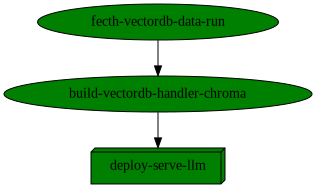

uid,start,state,name,parameters,results
...231aacee,Jun 16 15:01:34,completed,build-vectordb-handler-chroma,cache_dir=/v3io/projects/genai-tutorial-new/artifacts/cache,
...d0648e01,Jun 16 15:00:35,completed,fecth-vectordb-data-run,data_set=https://s3.wasabisys.com/iguazio/data/genai-tutorial/labelled_newscatcher_dataset.csv,


In [49]:
run_id = project.run(
    'main',
    arguments={"cache_dir" : CACHE_DIR,
               "data_set" : DATA_SET},
    watch=True)